In [1]:
#conda install -c conda-forge spacy-model-en_core_web_sm
import re
import pandas as pd
from time import time  # To time our operations
from collections import defaultdict  # For word frequency

import spacy  # For preprocessing

import string 
import nltk 
import numpy as np 
import math 
from tqdm import tqdm 

from spacy.matcher import Matcher 
from spacy.tokens import Span 
from spacy import displacy

import logging

logging.basicConfig(format="%(levelname)s - %(asctime)s: %(message)s", datefmt= '%H:%M:%S', level=logging.INFO)


##Stage1: convert pubmed text to csv. this section can be commented if we have the csv file

#convert abstracts to csv file from txt
# filename = 'pubmed-genesprote-set.txt' # this was downloaded from pubmed

# df = pd.read_csv(filename, sep='\n', header=None)
# # Keep track of keywords and abstracts
# keyword_list = []
# abstract_list = []
# pmid_list=[]

# keywords = ''
# abstract = ''
# for index, element in enumerate(df[0]):
#     # Enumerate all rows
#     if element[0:2] == 'AB':
#         # Add to the abstract string
#         abstract += element[6:]
#         counter = 1
#         while True:
#             new_element = df[0][index + counter]
#             if new_element[0:4] != '    ':
#                 break
#             else:
#                 abstract += new_element[6:]
#                 counter += 1
                

#     elif element[0:3] == 'OT ':
#         # Add to the keyword string, 6 if no *, 7 if *
#         if element[6] == '*':
#             keywords += ' | ' + element[7:]
#         else:
#             keywords += ' | ' + element[6:]
            
#     elif element[0:4] == 'PMID' and index > 0:
#         # If no abstract, add empty fields
#         if len(abstract) == 0:
#             keyword_list.append('EMPTY')
#             abstract_list.append('EMPTY')
#         else:
#             # New publication, append keywords and abstract and clear
#             pmid_list.append(element[6:])
#             keyword_list.append(keywords[3:])
#             abstract_list.append(abstract)
            
#         keywords = ''
#         abstract = ''

# # Append last keywords and abstract
# keyword_list.append(keywords)
# abstract_list.append(abstract)

# print('Looped through records and found ' + str(len(keyword_list)) + ' abstracts.')
# result_df = pd.DataFrame({'abstract': abstract_list, 'keywords': keyword_list})

# result_df.to_csv('woundabstracts.csv', index=False, encoding='utf-8')
# print(len(pmid_list))
# for i in range(0,len(pmid_list),100):    
#         f=open('pmids/pmid'+str(i)+'.txt', 'w')
#         for line in pmid_list[i:i+99]:
#             f.write(line+"\n")
#         f.close()

In [2]:

#stage 2:

df =pd.read_csv('woundabstracts.csv')

##print(df['abstract'])
df=df.dropna().reset_index(drop=True)
##send=[row.split(' ') for row in df]
nlp = spacy.load("en_core_web_sm", disable=["ner", "parser"]) # disabling Named Entity Recognition for speed

# this function removes stop words and lemmatizes the words
def cleaning(doc):
    txt=[token.lemma_ for token in doc if not token.is_stop]
    if len(txt) > 2:
        return ' '.join(txt)
brief_cleaning = (re.sub("[^A-Za-z1-9']+", ' ', str(row)).lower() for row in df['abstract'])
t = time()

txt = [cleaning(doc) for doc in nlp.pipe(brief_cleaning, batch_size=5000)]

print('Time to clean up everything: {} mins'.format(round((time() - t) / 60, 2)))

df_clean = pd.DataFrame({'abstract': txt})
df_clean = df_clean.dropna().drop_duplicates()
print(df_clean.shape)

# convert the dataframe to list of lists, so that we can use it as input in Word2Vec
sent = [row.split() for row in df_clean['abstract']]
print(sent[:2])

import multiprocessing

from gensim.models import Word2Vec
cores = multiprocessing.cpu_count() # Count the number of cores in a computer

w2v_model = Word2Vec(min_count=3,window=2,vector_size=50,sample=6e-5, alpha=0.03, min_alpha=0.0007, negative=20,workers=cores-1)

t = time()

w2v_model.build_vocab(sent, progress_per=10000)

print('Time to build vocab: {} mins'.format(round((time() - t) / 60, 2)))

t = time()

w2v_model.train(sent, total_examples=w2v_model.corpus_count, epochs=30, report_delay=1)

print('Time to train the model: {} mins'.format(round((time() - t) / 60, 2)))

##w2v_model.init_sims(replace=True)

# displays the words that were most similar to the word Wound.
print(w2v_model.wv.most_similar(positive=["wound"]))
##w2v_model.wv.similarity("moe_'s", 'tavern')





Time to clean up everything: 0.7 mins
(2207, 1)
[['wound', 'healing', 'important', 'physiological', 'process', 'maintain', 'integrity', 'skin', 'trauma', 'accident', 'intent', 'procedure', 'normal', 'wound', 'healing', 'involve', 'successive', 'overlap', 'phase', 'include', 'hemostasis', 'inflammatory', 'phase', 'proliferative', 'phase', 'remodeling', 'phase', 'aberration', 'wound', 'healing', 'excessive', 'wound', 'heal', 'hypertrophic', 'scar', 'keloid', 'chronic', 'wound', 'ulcer', 'impair', 'normal', 'physical', 'function', 'large', 'number', 'sophisticated', 'experimental', 'study', 'provide', 'insight', 'wound', 'healing', 'article', 'highlight', 'information', '2', '1', 'main', 'text', 'include', 'wound', 'healing', 'ii', 'wound', 'healing', 'fetus', 'adult', 'iii', 'prostaglandin', 'wound', 'healing', 'iv', 'pathogenesis', 'excessive', 'wound', 'healing', 'v', 'epidemiology', 'excessive', 'wound', 'healing', 'vi', 'vitro', 'vivo', 'study', 'excessive', 'wound', 'healing', 'vii'

INFO - 16:57:34: Word2Vec lifecycle event {'params': 'Word2Vec(vocab=0, vector_size=50, alpha=0.03)', 'datetime': '2022-04-19T16:57:34.281714', 'gensim': '4.1.2', 'python': '3.8.12 (default, Oct 12 2021, 03:01:40) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.22000-SP0', 'event': 'created'}
INFO - 16:57:34: collecting all words and their counts
INFO - 16:57:34: PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO - 16:57:34: collected 14966 word types from a corpus of 322018 raw words and 2207 sentences
INFO - 16:57:34: Creating a fresh vocabulary
INFO - 16:57:34: Word2Vec lifecycle event {'msg': 'effective_min_count=3 retains 7702 unique words (51.46331685153014%% of original 14966, drops 7264)', 'datetime': '2022-04-19T16:57:34.477175', 'gensim': '4.1.2', 'python': '3.8.12 (default, Oct 12 2021, 03:01:40) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.22000-SP0', 'event': 'prepare_vocab'}
INFO - 16:57:34: Word2Vec lifecycle event {'msg': 'ef

Time to build vocab: 0.01 mins


INFO - 16:57:35: worker thread finished; awaiting finish of 6 more threads
INFO - 16:57:35: worker thread finished; awaiting finish of 5 more threads
INFO - 16:57:35: worker thread finished; awaiting finish of 4 more threads
INFO - 16:57:35: worker thread finished; awaiting finish of 3 more threads
INFO - 16:57:35: worker thread finished; awaiting finish of 2 more threads
INFO - 16:57:35: worker thread finished; awaiting finish of 1 more threads
INFO - 16:57:35: worker thread finished; awaiting finish of 0 more threads
INFO - 16:57:35: EPOCH - 2 : training on 322018 raw words (150471 effective words) took 0.2s, 753796 effective words/s
INFO - 16:57:35: worker thread finished; awaiting finish of 6 more threads
INFO - 16:57:35: worker thread finished; awaiting finish of 5 more threads
INFO - 16:57:35: worker thread finished; awaiting finish of 4 more threads
INFO - 16:57:35: worker thread finished; awaiting finish of 3 more threads
INFO - 16:57:35: worker thread finished; awaiting finish

INFO - 16:57:37: EPOCH - 14 : training on 322018 raw words (150739 effective words) took 0.3s, 573894 effective words/s
INFO - 16:57:37: worker thread finished; awaiting finish of 6 more threads
INFO - 16:57:37: worker thread finished; awaiting finish of 5 more threads
INFO - 16:57:37: worker thread finished; awaiting finish of 4 more threads
INFO - 16:57:37: worker thread finished; awaiting finish of 3 more threads
INFO - 16:57:37: worker thread finished; awaiting finish of 2 more threads
INFO - 16:57:37: worker thread finished; awaiting finish of 1 more threads
INFO - 16:57:37: worker thread finished; awaiting finish of 0 more threads
INFO - 16:57:37: EPOCH - 15 : training on 322018 raw words (150630 effective words) took 0.2s, 785725 effective words/s
INFO - 16:57:37: worker thread finished; awaiting finish of 6 more threads
INFO - 16:57:37: worker thread finished; awaiting finish of 5 more threads
INFO - 16:57:37: worker thread finished; awaiting finish of 4 more threads
INFO - 16:

INFO - 16:57:39: worker thread finished; awaiting finish of 1 more threads
INFO - 16:57:39: worker thread finished; awaiting finish of 0 more threads
INFO - 16:57:39: EPOCH - 27 : training on 322018 raw words (150884 effective words) took 0.2s, 927596 effective words/s
INFO - 16:57:39: worker thread finished; awaiting finish of 6 more threads
INFO - 16:57:39: worker thread finished; awaiting finish of 5 more threads
INFO - 16:57:39: worker thread finished; awaiting finish of 4 more threads
INFO - 16:57:39: worker thread finished; awaiting finish of 3 more threads
INFO - 16:57:39: worker thread finished; awaiting finish of 2 more threads
INFO - 16:57:39: worker thread finished; awaiting finish of 1 more threads
INFO - 16:57:39: worker thread finished; awaiting finish of 0 more threads
INFO - 16:57:39: EPOCH - 28 : training on 322018 raw words (150633 effective words) took 0.2s, 859907 effective words/s
INFO - 16:57:39: worker thread finished; awaiting finish of 6 more threads
INFO - 16:

Time to train the model: 0.09 mins
[('healing', 0.8381890058517456), ('heal', 0.7644937038421631), ('quick', 0.712945818901062), ('closure', 0.707985520362854), ('acceleration', 0.7064684629440308), ('fast', 0.7038348317146301), ('wh', 0.701798677444458), ('accelerate', 0.6973049640655518), ('process', 0.6890731453895569), ('cutaneous', 0.6842600107192993)]


In [3]:
print(w2v_model.wv.most_similar(positive=["wound"]))

[('healing', 0.8381890058517456), ('heal', 0.7644937038421631), ('quick', 0.712945818901062), ('closure', 0.707985520362854), ('acceleration', 0.7064684629440308), ('fast', 0.7038348317146301), ('wh', 0.701798677444458), ('accelerate', 0.6973049640655518), ('process', 0.6890731453895569), ('cutaneous', 0.6842600107192993)]


In [4]:
#the words that were captured by the model
print(w2v_model.wv.key_to_index)

#returns the probability of finding wound and healing together
w2v_model.wv.similarity("wound", 'healing')


{'wound': 0, 'healing': 1, 'cell': 2, '1': 3, 'group': 4, 'study': 5, 'tissue': 6, 'skin': 7, '2': 8, 'factor': 9, 'expression': 10, 'result': 11, 'effect': 12, 'collagen': 13, 'growth': 14, 'treatment': 15, 'increase': 16, 'day': 17, 'protein': 18, 'show': 19, '3': 20, 'control': 21, '5': 22, 'fibroblast': 23, 'process': 24, 'mouse': 25, 'model': 26, 'proliferation': 27, 'promote': 28, 'treat': 29, 'migration': 30, 'rat': 31, 'compare': 32, 'level': 33, 'significantly': 34, 'p': 35, 'human': 36, 'high': 37, 'repair': 38, '4': 39, 'induce': 40, 'inflammatory': 41, 'role': 42, 'diabetic': 43, 'method': 44, 'heal': 45, 'potential': 46, 'gene': 47, 'hydrogel': 48, 'vitro': 49, 'formation': 50, 'activity': 51, '6': 52, 'analysis': 53, '7': 54, 'il': 55, 'vivo': 56, 'conclusion': 57, 'evaluate': 58, 'matrix': 59, 'regeneration': 60, 'keratinocyte': 61, 'demonstrate': 62, 'patient': 63, 'tgf': 64, 'injury': 65, 'investigate': 66, 'accelerate': 67, 'application': 68, 'scaffold': 69, 'time': 7

0.838189

In [5]:
# read_file = pd.read_csv ('proteins.txt',sep='\n',header=None)
# read_file.columns = ['Name']
# read_file.to_csv ('protein.csv', index=None)


In [6]:
# read_file = pd.read_csv ('genes.txt',sep='\n',header=None)
# read_file.columns = ['Name']
# read_file.to_csv ('gene.csv', index=None)

In [7]:
#read the list of protein and gene names
proteins=pd.read_csv('protein.csv')
genes=pd.read_csv('gene.csv')
genes=genes.dropna().reset_index(drop=True)

In [8]:
# Now check the similarity of each gene with the word Wound.
brief_cleaning = (re.sub(" ", '', str(row)).lower() for row in genes['Name'])
genes=pd.DataFrame({'Name': brief_cleaning})
woundgenelist=[]
for index, row in genes. iterrows():
    try:
        #print(row['Name']+"--")
        print(w2v_model.wv.similarity("wound",row['Name'])," ",end='')
    except:
        continue
    print(row['Name'])
    woundgenelist.append(row['Name'])

0.029942714  genome
-0.066696584  antigen
0.31541762  apc
0.2012101  ar
0.40335238  ccr4
0.29622257  chaperone
0.35108763  crtac1
0.29199484  cytokine
0.25084537  ecd
0.10885522  enzyme
0.26787484  fas
0.38080806  fgg
-0.05770595  fusion
0.22541858  gst
0.306439  hbegf
0.315912  mal
0.18548653  microrna
0.31323367  mmp
0.2964443  nat
0.41746435  neoplastic
0.18540135  neuropeptide
0.42137972  oat
0.22618058  pdlim5
0.18733527  piezo1
0.093843356  poly
0.30188018  sea
0.40810943  smoc1
0.35745624  tlr5
0.029942714  genome


In [9]:
# Now check the similarity of each protein with the word Wound.
brief_cleaning = (re.sub(" ", '', str(row)).lower() for row in proteins['Name'])
proteins=pd.DataFrame({'Name': brief_cleaning})
woundproteinlist=[]
for index, row in proteins. iterrows():
    try:
        print(w2v_model.wv.similarity("wound",row['Name'])," ",end='')
    except:
        continue
    print(row['Name'])
    woundproteinlist.append(row['Name'])

0.18348233  adhesion
0.15421349  adhesive
0.1476535  alpha
0.3461706  amyloid
0.48250255  animal
0.10436357  beta
0.3290891  coagulation
0.21301405  collagen
0.15104759  cytokeratin
0.29199484  cytokine
0.36517662  dysf
0.20554465  dysferlin
0.13112524  elastin
0.3868329  erythropoietin
0.093820624  f
0.33621597  ferritin
0.032778993  fibrinogen
-0.05770595  fusion
0.08748731  glycosaminoglycans
0.09865551  hemoglobin
0.06322749  heparin
0.3559981  insulin
0.1572082  keratin
0.22133052  latex
0.1984507  lectin
0.38052273  lens
0.4934013  lyst
0.053574048  messenger
0.24957775  osteocalcin
0.19227317  osteopontin
0.49456984  perforin
0.27026033  pigment
0.25334996  prealbumin
0.13468772  procollagen
0.012029501  c
0.012029501  c
0.17312661  carbonyl
0.012473613  family
0.039093733  hormone
0.07168443  nitrogen
0.14726612  pattern
0.29703507  s
-0.053071864  proteoglycan
0.2352244  proteome
0.025444947  receptor
0.33293322  respiratory
0.30175227  scaffold
0.26221937  secretory
0.1723532

In [21]:
##Now check the similarity between each protein and genes that were similar with wound.
print("\t    Protein\tgene\n")
gp={}
for i in woundgenelist:
    for j in woundproteinlist:
        print(w2v_model.wv.similarity(i,j)," ",end=' ')
        print(j,"--",i)
        if(i in gp):
            gp[i].add((j,w2v_model.wv.similarity(i,j)))
        else:
            gp[i]={(j,w2v_model.wv.similarity(i,j))}
        

	    Protein	gene

0.066637725   adhesion -- genome
0.3131584   adhesive -- genome
0.19680431   alpha -- genome
0.41296864   amyloid -- genome
0.31142887   animal -- genome
0.1777938   beta -- genome
0.22824961   coagulation -- genome
0.14385411   collagen -- genome
0.31648213   cytokeratin -- genome
0.27416283   cytokine -- genome
0.6505822   dysf -- genome
0.39974695   dysferlin -- genome
0.38115105   elastin -- genome
0.2789089   erythropoietin -- genome
0.25934234   f -- genome
0.62621015   ferritin -- genome
0.4645853   fibrinogen -- genome
0.2953734   fusion -- genome
0.5012816   glycosaminoglycans -- genome
0.45861462   hemoglobin -- genome
0.37890163   heparin -- genome
0.12115449   insulin -- genome
0.23016116   keratin -- genome
0.65860105   latex -- genome
0.60867655   lectin -- genome
0.52825785   lens -- genome
0.36553782   lyst -- genome
0.52811205   messenger -- genome
0.49216446   osteocalcin -- genome
0.6522168   osteopontin -- genome
0.4488216   perforin -- genome
0.1

0.7647158   lens -- chaperone
0.6873476   lyst -- chaperone
0.4763396   messenger -- chaperone
0.6733506   osteocalcin -- chaperone
0.6741508   osteopontin -- chaperone
0.71219075   perforin -- chaperone
0.5279704   pigment -- chaperone
0.6644329   prealbumin -- chaperone
0.43156567   procollagen -- chaperone
0.37435493   c -- chaperone
0.37435493   c -- chaperone
0.41398972   carbonyl -- chaperone
0.51442856   family -- chaperone
0.39561373   hormone -- chaperone
0.530003   nitrogen -- chaperone
0.45412523   pattern -- chaperone
0.1817437   s -- chaperone
0.5050845   proteoglycan -- chaperone
0.56697726   proteome -- chaperone
0.58870256   receptor -- chaperone
0.78424954   respiratory -- chaperone
0.29250386   scaffold -- chaperone
0.6417192   secretory -- chaperone
0.3574925   silk -- chaperone
0.5295097   smad2 -- chaperone
0.7951685   smad4 -- chaperone
0.34728718   structural -- chaperone
0.51402   synthetic -- chaperone
0.48222366   thymosin -- chaperone
0.61483276   transferrin

0.46166825   fibrinogen -- fusion
1.0   fusion -- fusion
0.4520556   glycosaminoglycans -- fusion
0.2009204   hemoglobin -- fusion
0.63700014   heparin -- fusion
0.29583865   insulin -- fusion
0.26847342   keratin -- fusion
0.28560138   latex -- fusion
0.40035075   lectin -- fusion
0.42117116   lens -- fusion
0.2783584   lyst -- fusion
0.33995017   messenger -- fusion
0.39647925   osteocalcin -- fusion
0.3046042   osteopontin -- fusion
0.19188982   perforin -- fusion
0.33393165   pigment -- fusion
0.29195976   prealbumin -- fusion
0.2596302   procollagen -- fusion
0.15452012   c -- fusion
0.15452012   c -- fusion
0.10981077   carbonyl -- fusion
0.45656636   family -- fusion
0.3732891   hormone -- fusion
0.14258434   nitrogen -- fusion
0.27368647   pattern -- fusion
-0.096546575   s -- fusion
0.42703474   proteoglycan -- fusion
0.29503906   proteome -- fusion
0.4407843   receptor -- fusion
0.38830435   respiratory -- fusion
0.37236154   scaffold -- fusion
0.3471444   secretory -- fusion

0.47075525   nitrogen -- neoplastic
0.33923626   pattern -- neoplastic
0.30078512   s -- neoplastic
0.4732507   proteoglycan -- neoplastic
0.62618864   proteome -- neoplastic
0.47456342   receptor -- neoplastic
0.8453711   respiratory -- neoplastic
0.4265277   scaffold -- neoplastic
0.77202106   secretory -- neoplastic
0.3697914   silk -- neoplastic
0.4544236   smad2 -- neoplastic
0.7746321   smad4 -- neoplastic
0.43023163   structural -- neoplastic
0.4539404   synthetic -- neoplastic
0.5633849   thymosin -- neoplastic
0.64658105   transferrin -- neoplastic
0.64806443   tropomyosin -- neoplastic
0.8492345   ubiquitin -- neoplastic
0.6989118   urine -- neoplastic
0.47800612   vimentin -- neoplastic
0.6833708   vitronectin -- neoplastic
0.2540456   adhesion -- neuropeptide
0.34956542   adhesive -- neuropeptide
0.33554932   alpha -- neuropeptide
0.6281091   amyloid -- neuropeptide
0.20646897   animal -- neuropeptide
0.48335046   beta -- neuropeptide
0.5133573   coagulation -- neuropeptide

0.23456287   c -- poly
0.23456287   c -- poly
0.30118692   carbonyl -- poly
0.13746692   family -- poly
0.1498223   hormone -- poly
0.27824622   nitrogen -- poly
-0.043431662   pattern -- poly
0.20512134   s -- poly
0.1610758   proteoglycan -- poly
0.038639426   proteome -- poly
0.075918645   receptor -- poly
0.32580715   respiratory -- poly
0.44728324   scaffold -- poly
0.15436718   secretory -- poly
0.47492915   silk -- poly
0.094411075   smad2 -- poly
0.22646803   smad4 -- poly
0.057511058   structural -- poly
0.5520128   synthetic -- poly
0.123287685   thymosin -- poly
0.39206517   transferrin -- poly
0.2034712   tropomyosin -- poly
0.37574613   ubiquitin -- poly
0.28456724   urine -- poly
0.09974449   vimentin -- poly
0.18408498   vitronectin -- poly
0.091605164   adhesion -- sea
0.43697697   adhesive -- sea
-0.0141588915   alpha -- sea
0.40054527   amyloid -- sea
0.369074   animal -- sea
0.01632826   beta -- sea
0.27951634   coagulation -- sea
0.045160618   collagen -- sea
-0.194

C:\Users\Yoshita\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\Yoshita\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
C:\Users\Yoshita\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\Yoshita\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
C:\Users\Yoshita\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\Yoshita\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py

C:\Users\Yoshita\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\Yoshita\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
C:\Users\Yoshita\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\Yoshita\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
C:\Users\Yoshita\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\Yoshita\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py

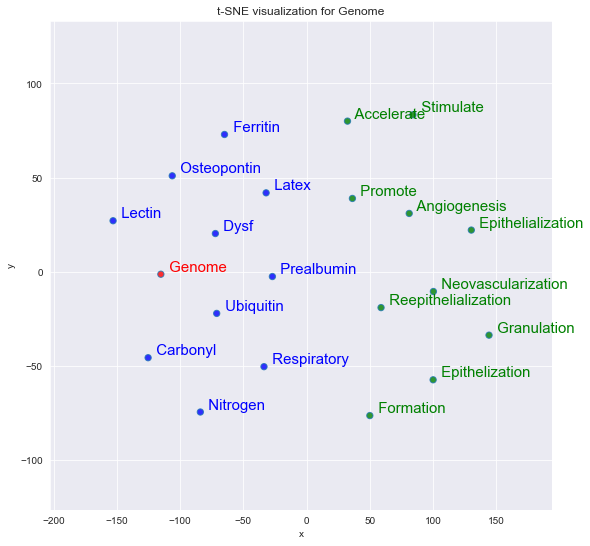

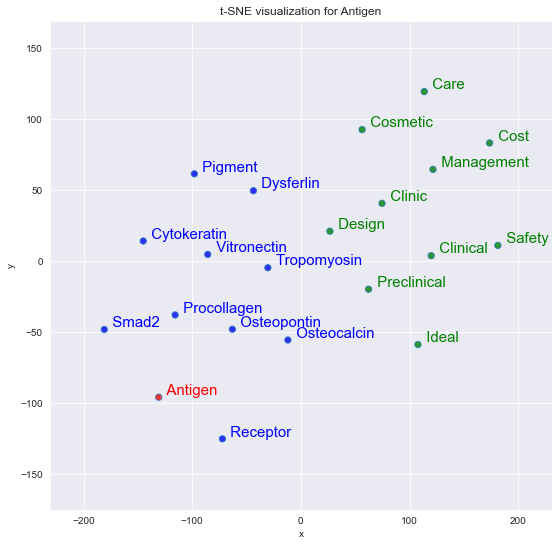

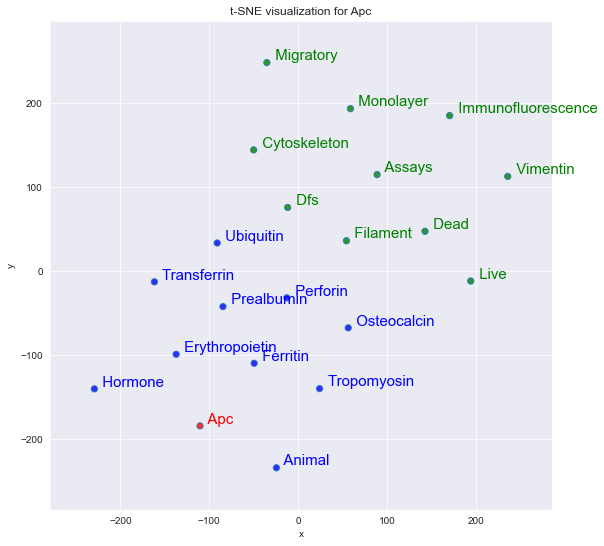

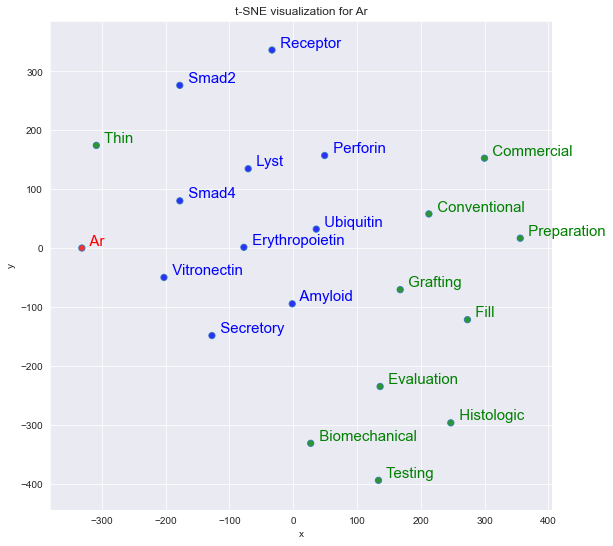

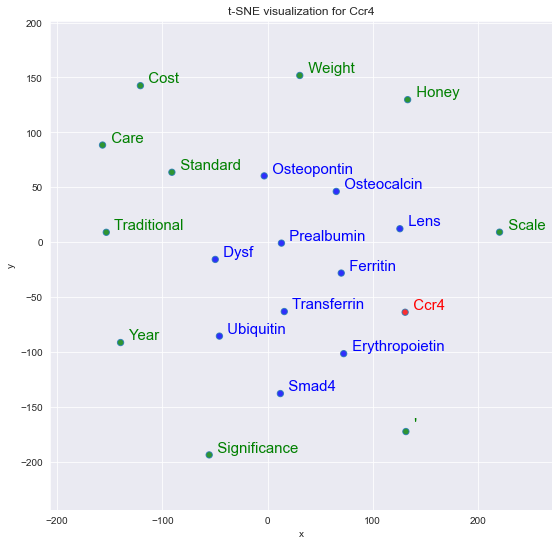

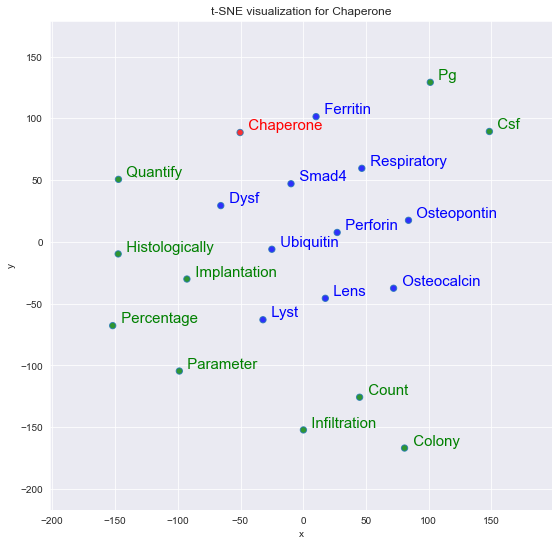

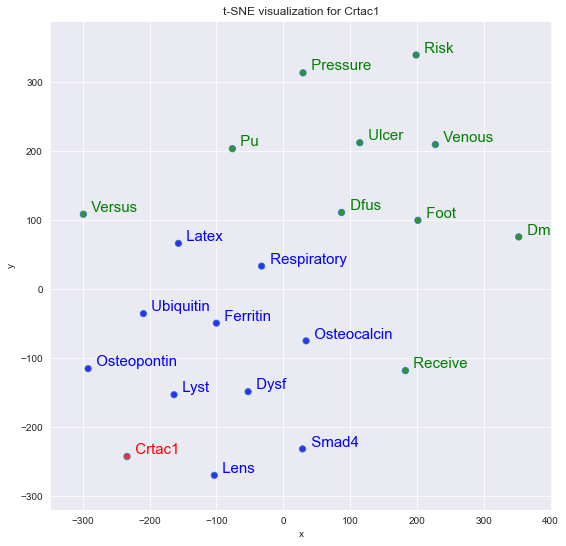

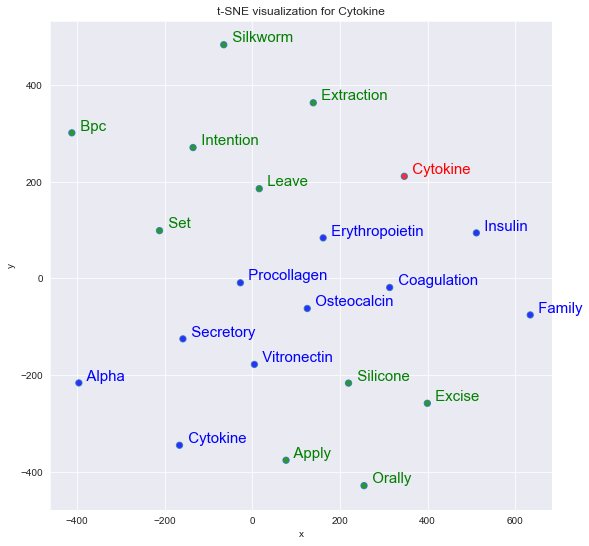

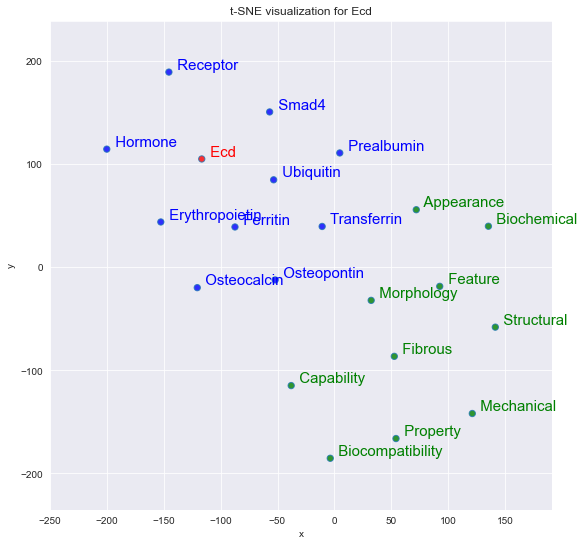

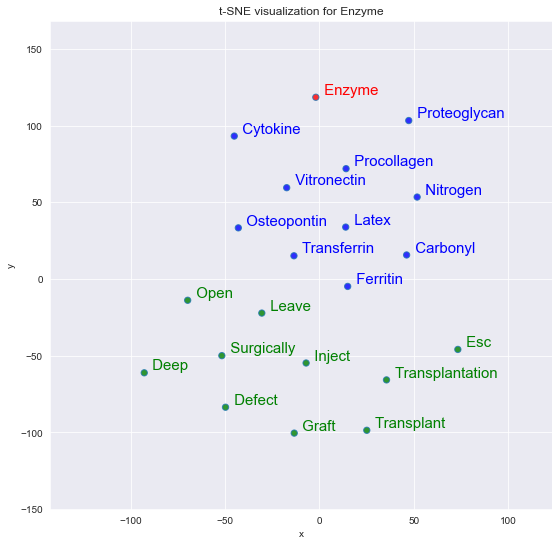

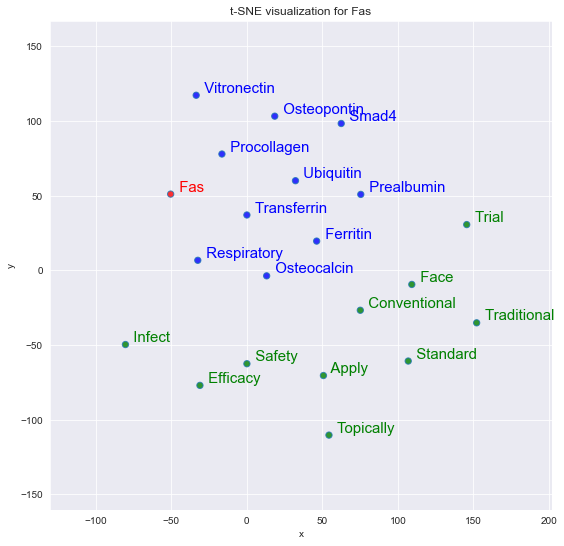

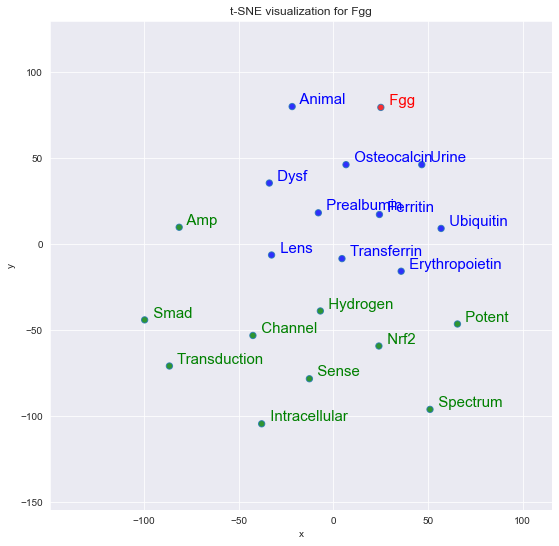

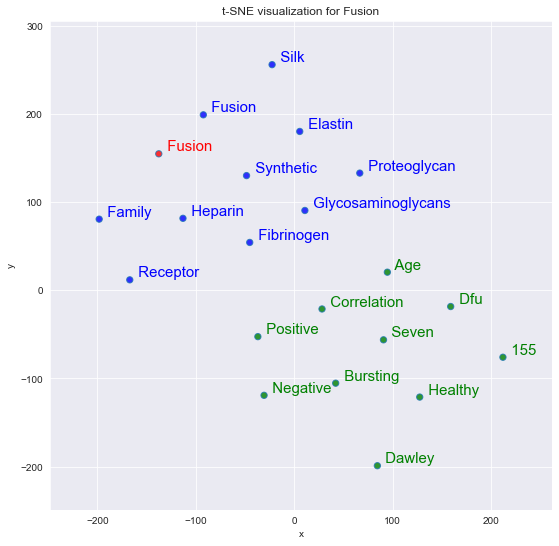

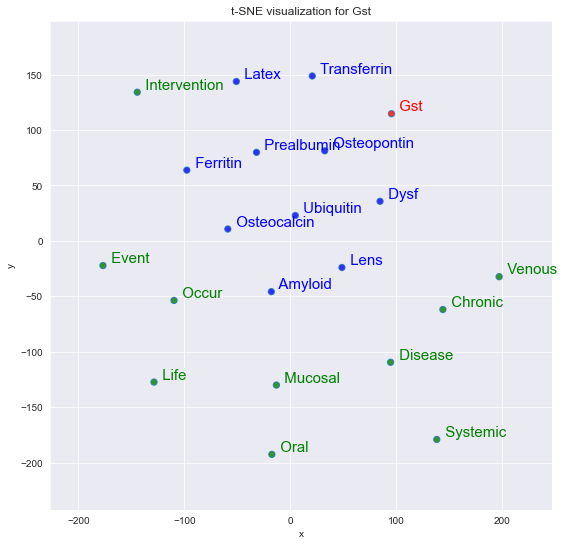

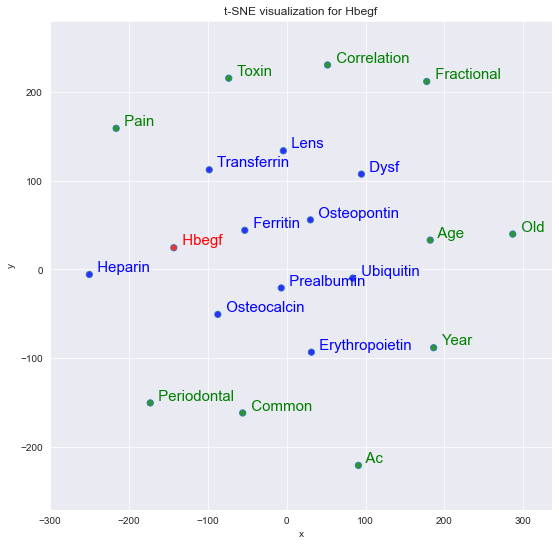

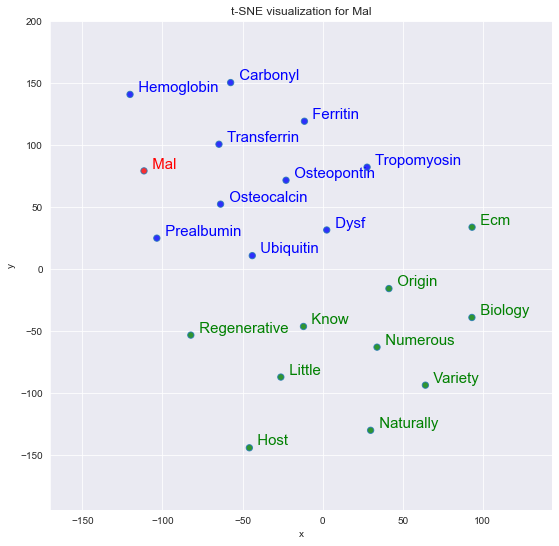

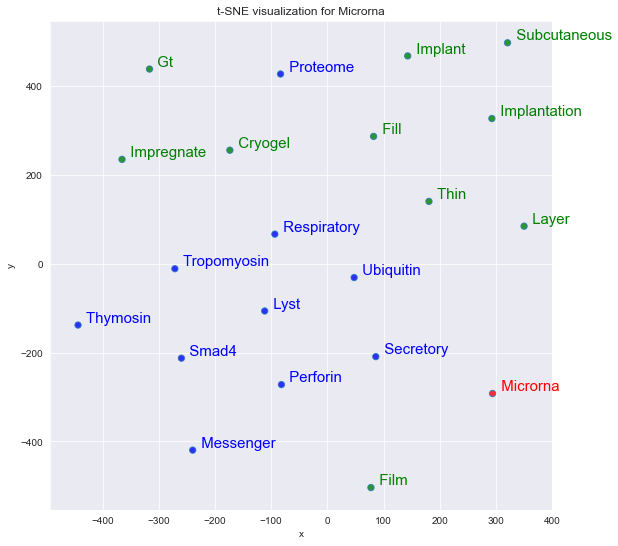

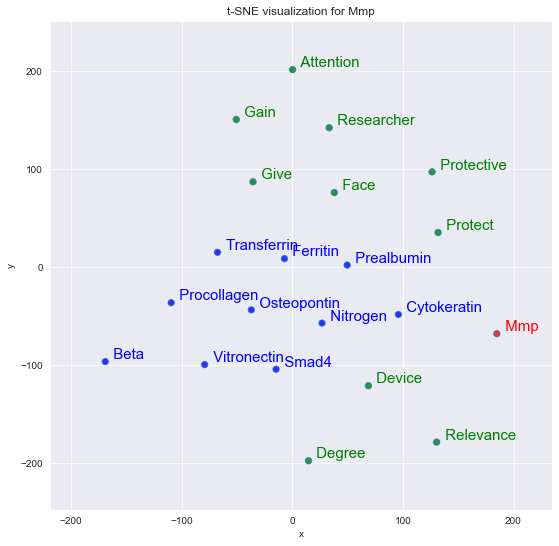

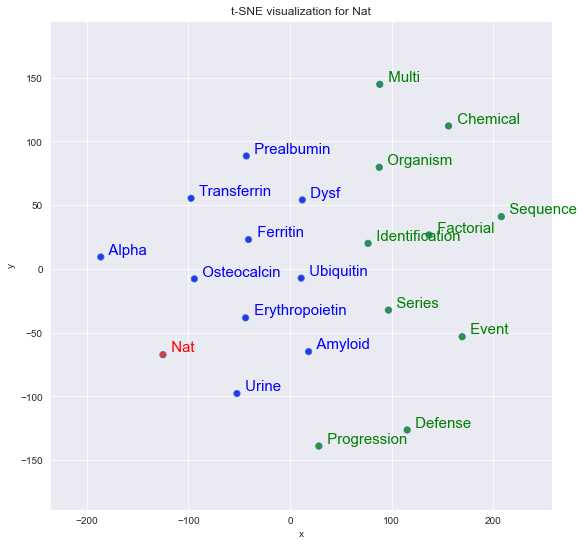

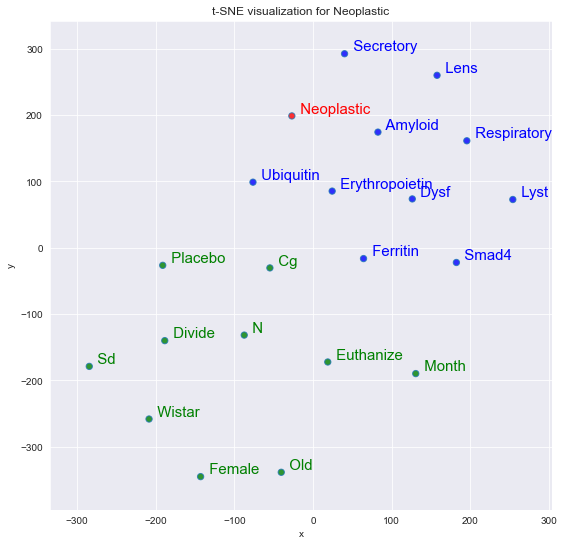

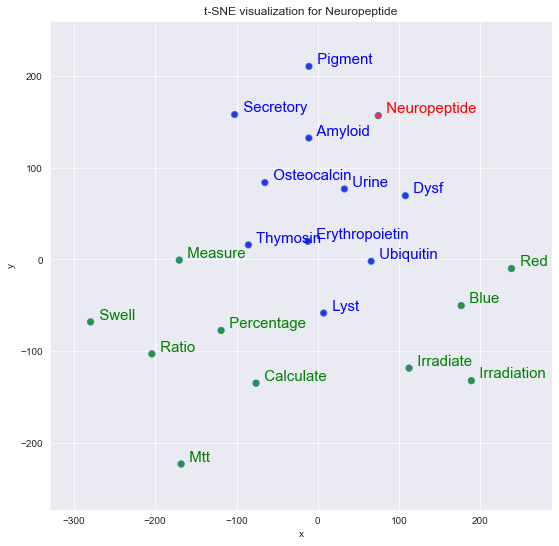

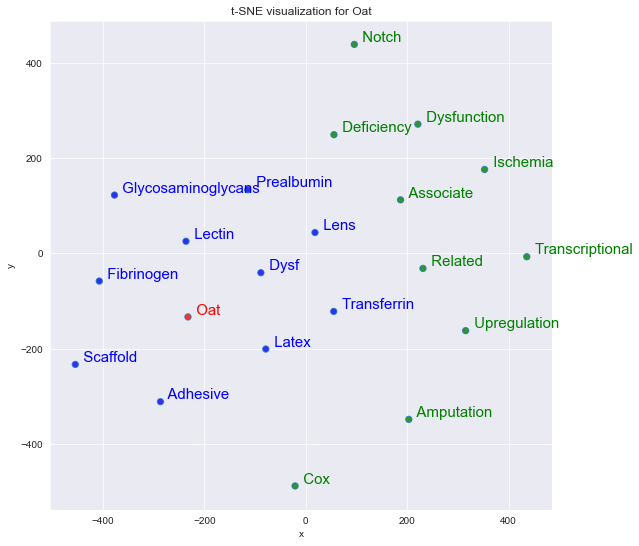

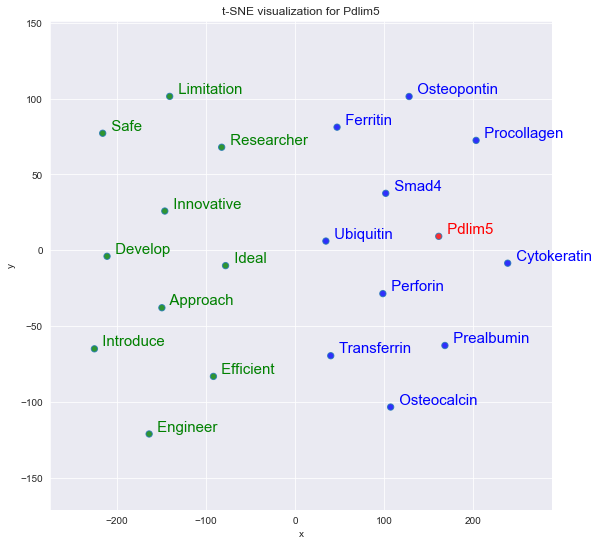

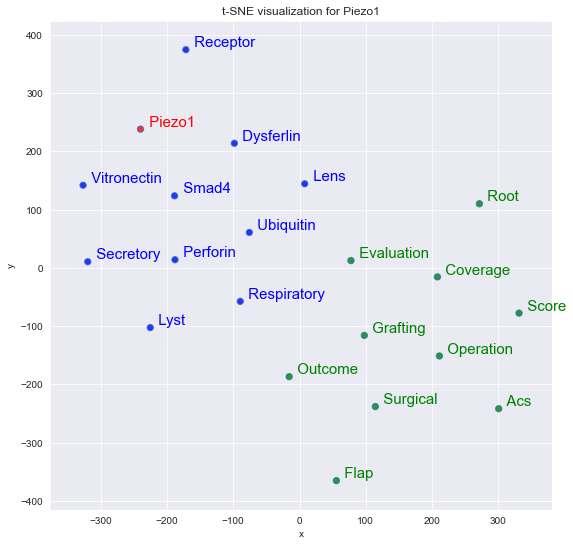

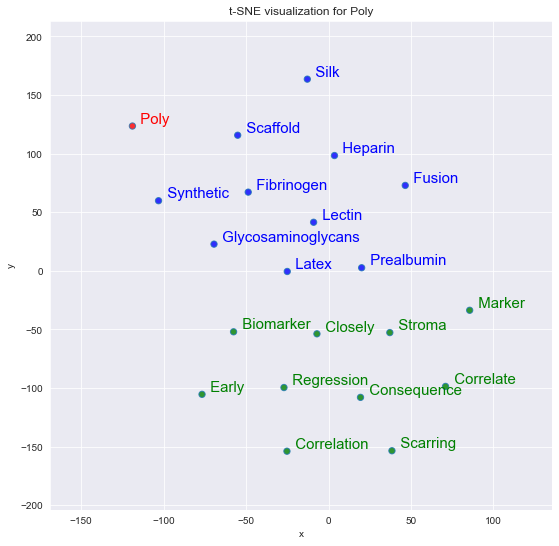

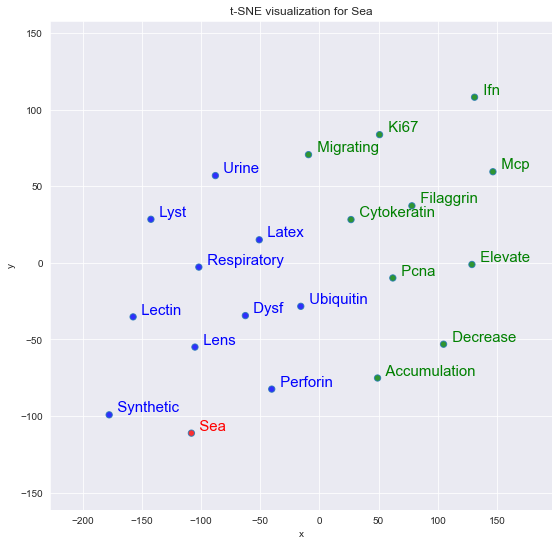

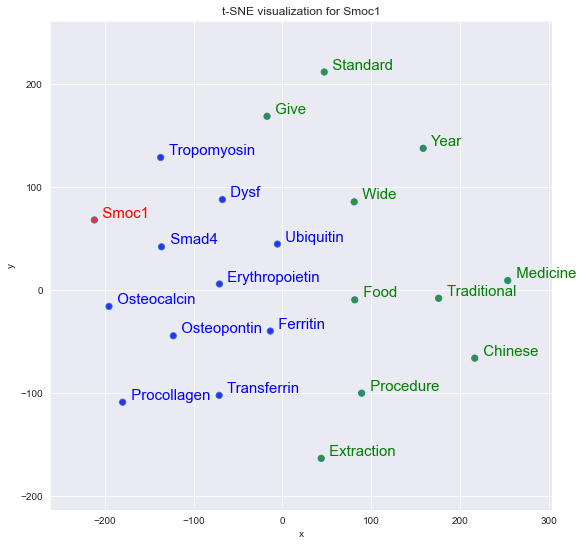

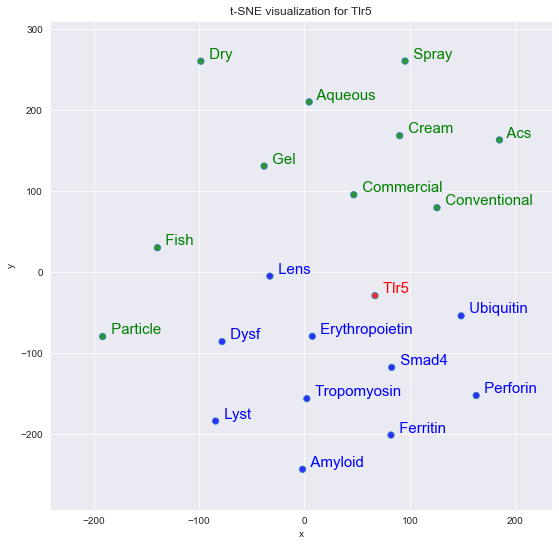

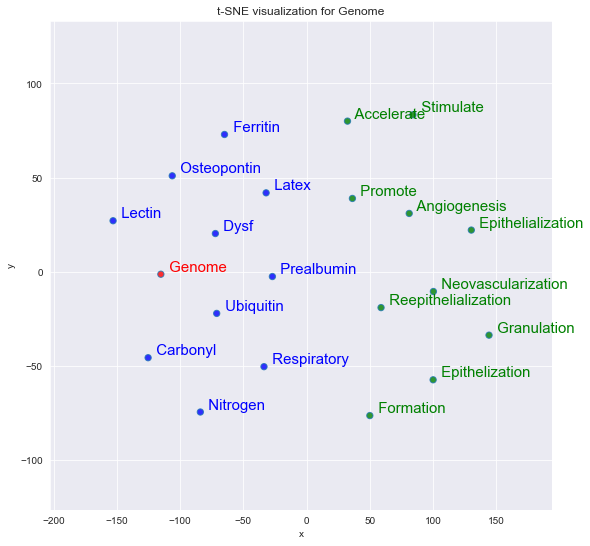

In [22]:
import matplotlib.pyplot as plt
%matplotlib inline
 
import seaborn as sns
sns.set_style("darkgrid")

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Bluw words are proteins, red word is gene and green words are most dissimilar words
def tsnescatterplot(model, word, list_names,gp):
    """ Plot in seaborn the results from the t-SNE dimensionality reduction algorithm of the vectors of a query word,
    its list of most similar words, and a list of words.
    """
    arrays = np.empty((0, 50), dtype='f')
    word_labels = [word]
    color_list  = ['red']

    # adds the vector of the query word
    arrays = np.append(arrays, model.wv.__getitem__([word]), axis=0)
    
    # gets list of most similar words
    if(word in gp):
        close_words=list(gp[word])
        close_words.sort(key=lambda x: x[1], reverse=True)
        close_words=close_words[:10]
    else:
        close_words = model.wv.most_similar([word])
    
    # adds the vector for each of the closest words to the array
    for wrd_score in close_words:
        wrd_vector = model.wv.__getitem__([wrd_score[0]])
        word_labels.append(wrd_score[0])
        color_list.append('blue')
        arrays = np.append(arrays, wrd_vector, axis=0)
    
    # adds the vector for each of the words from list_names to the array
    for wrd in list_names:
        wrd_vector = model.wv.__getitem__([wrd])
        word_labels.append(wrd)
        color_list.append('green')
        arrays = np.append(arrays, wrd_vector, axis=0)
        
    # Reduces the dimensionality from 300 to 50 dimensions with PCA
    reduc = PCA().fit_transform(arrays)
        # Finds t-SNE coordinates for 2 dimensions
    np.set_printoptions(suppress=True)
    
    Y = TSNE(n_components=2, random_state=0, perplexity=15).fit_transform(reduc)
    
    # Sets everything up to plot
    df = pd.DataFrame({'x': [x for x in Y[:, 0]],
                       'y': [y for y in Y[:, 1]],
                       'words': word_labels,
                       'color': color_list})
    
    fig, _ = plt.subplots()
    fig.set_size_inches(9, 9)
    
    # Basic plot
    p1 = sns.regplot(data=df,
                     x="x",
                     y="y",
                     fit_reg=False,
                     marker="o",
                     scatter_kws={'s': 40,
                                  'facecolors': df['color']
                                 }
                    )
        # Adds annotations one by one with a loop
    for line in range(0, df.shape[0]):
         p1.text(df["x"][line],
                 df['y'][line],
                 '  ' + df["words"][line].title(),
                 horizontalalignment='left',
                 verticalalignment='bottom', size='medium',
                 color=df['color'][line],
                 weight='normal'
                ).set_size(15)

    
    plt.xlim(Y[:, 0].min()-50, Y[:, 0].max()+50)
    plt.ylim(Y[:, 1].min()-50, Y[:, 1].max()+50)
            
    plt.title('t-SNE visualization for Gene {}'.format(word.title()))

# 10 Most similar words vs. 10 Most dissimilar
for i in woundgenelist:
#     for j in woundproteinlist:
    tsnescatterplot(w2v_model, i, [i[0] for i in w2v_model.wv.most_similar(negative=[i])],gp)

# print("\t    Protein\tgene\n")
# for i in woundgenelist:
#     for j in woundproteinlist:
#         print(w2v_model.wv.similarity(i,j)," ",end=' ')
#         print(j,"--",i)